# TFM - Deteccion de productos comestibles en lineales de venta # 

## Autor:Raul Rodríguez Octavio ##

### Librerias y Parametros ###

In [94]:
#Importacion de librerías

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
    
from tensorflow import keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.mobilenet import preprocess_input
#Capas en orden
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
#Matar el Keras de detras
from tensorflow.python.keras import backend as K
#Metricas de rendimiento
import itertools
from mlxtend.evaluate import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
K.clear_session()


#Ubicacion de las imagenes de entrenamiento y validacion

data_entrenamiento = './Datos/entrenamiento'
data_validacion = './Datos/validacion'

#Configuración de parámetros de entrenamiento

#Numero de veces de iteracion de nuestro modelo
epocas=20
#Altura y longitud por pixel
longitud, altura = 150, 150
#Imágenes por paso
batch_size = 32
#Pasos por época
pasos = 20
pasos_validacion = 1
#Numero de filtros en cada convolucion(Profundidad)
filtrosConv1 = 32
filtrosConv2 = 64
tamano_filtro1 = (3, 3)#Primera convolucion
tamano_filtro2 = (2, 2)#Segunda convolucion
tamano_pool = (2, 2)#Mejora el avance de la convolución
clases = 2 #Numero de clases que tenemos

#Ajustes para una solución óptima
lr = 0.0004


##Preprocesamiento de nuestras imagenes

entrenamiento_datagen = ImageDataGenerator(
    #Nuestros valores tienen que estar entre o y 1
    rescale=1. / 255,
    #Inclina las imagenes
    shear_range=0.2,
    #Zoom a las imagenes
    zoom_range=0.2,
    #Invierte las imágenes
    horizontal_flip=True)

#Para la validación no hago modificaciones

test_datagen = ImageDataGenerator(rescale=1. / 255)
#Preparacion carpeta entrenamiento
entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')
#Preparacion carpeta validacion
validacion_generador = test_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='categorical')
print(entrenamiento_generador.class_indices)

Found 239 images belonging to 2 classes.
Found 239 images belonging to 2 classes.
{'ProductosComestibles': 0, 'ProductosNoComestibles': 1}


In [95]:
#Implementamos los pasos de entrenamiento y validacion ideal (Total de imagenes entre el batchsize)
#cada epoca se va a dividir en XX pasos
pasos_entrenamiento= entrenamiento_generador.n//entrenamiento_generador.batch_size
print(pasos_entrenamiento)
#cada epoca se va a validar YY veces
pasos_validacion= validacion_generador.n//validacion_generador.batch_size

7


### Modelo ###

In [96]:
#Creacion de la red CNN

cnn = Sequential()
cnn.add(Convolution2D(filtrosConv1, tamano_filtro1, padding ="same", input_shape=(longitud, altura, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

cnn.add(Convolution2D(filtrosConv2, tamano_filtro2, padding ="same"))
cnn.add(MaxPooling2D(pool_size=tamano_pool))

#1 solo plano
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
#Evito sobreajustar
cnn.add(Dropout(0.5))
#Otra capa densa pero con el numero de neuronas de uestras clases.Softmax nos saca las probabildades
cnn.add(Dense(clases, activation='softmax'))

cnn.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(lr=lr),
            metrics=['accuracy'])

H=cnn.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=pasos_entrenamiento,
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=pasos_validacion)


Epoch 1/20
7/7 [==============================] - 3s 472ms/step - loss: 6.8799 - accuracy: 0.4464 - val_loss: 0.8389 - val_accuracy: 0.6786
Epoch 2/20
7/7 [==============================] - 3s 438ms/step - loss: 2.2361 - accuracy: 0.5894 - val_loss: 1.1107 - val_accuracy: 0.6696
Epoch 3/20
7/7 [==============================] - 3s 370ms/step - loss: 1.3685 - accuracy: 0.6377 - val_loss: 0.7999 - val_accuracy: 0.7232
Epoch 4/20
7/7 [==============================] - 2s 329ms/step - loss: 0.7456 - accuracy: 0.7198 - val_loss: 0.4742 - val_accuracy: 0.7679
Epoch 5/20
7/7 [==============================] - 2s 337ms/step - loss: 0.4860 - accuracy: 0.7723 - val_loss: 0.4271 - val_accuracy: 0.8438
Epoch 6/20
7/7 [==============================] - 2s 325ms/step - loss: 0.4445 - accuracy: 0.8068 - val_loss: 0.3676 - val_accuracy: 0.8929
Epoch 7/20
7/7 [==============================] - 2s 351ms/step - loss: 0.4153 - accuracy: 0.8213 - val_loss: 0.3298 - val_accuracy: 0.8795
Epoch 8/20
7/7 [====

In [97]:
#impresion del modelo
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               22429952  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

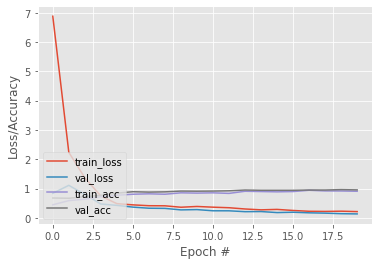

In [98]:
#Evaluacion del modelo
N = epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"], label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N),H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,N),H.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

#Objetivo --> train_loss: tiene que ir reduciendose
#Objetivo --> train_acc: tiene que ir subiendo

In [99]:
#Generador de las imagenes de la carpeta prueba
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    directory="./Datos/prueba",
    target_size=(altura,longitud),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
#llamanos a predict_generator , se lo aplicamos a nuestro modelo cnn ,la cantidad de pasos
pred=cnn.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

Found 30 images belonging to 1 classes.
30/30 [==============================] - 0s 10ms/step


### Comparacion de los resultados ###

In [100]:
#Predicciones de la carpeta prueba
#Saco las etiquetas asociadas a los numeros de las predicciones 
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)
print(type(predicted_class_indices))

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 1]
<class 'numpy.ndarray'>


In [101]:
#Voy a realizar una comparacion
labels = (entrenamiento_generador.class_indices)
print(entrenamiento_generador.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

{'ProductosComestibles': 0, 'ProductosNoComestibles': 1}


In [102]:
#Saco las etiquetas asociadas a los numeros de la carpeta prueba
filenames=test_generator.filenames
real_class_indices=[]
for i in range (0,len(filenames)):
    your_path = filenames[i]
    path_list = your_path.split(os.sep)
#    print(path_list)
    if("pc" in path_list[1]) :
        real_class_indices.append(0)
    if("pnc" in path_list[1]) :
        real_class_indices.append(1)
print (real_class_indices)
print (len(real_class_indices))
real_class_indices = np.array(real_class_indices)
print (type(real_class_indices))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
30
<class 'numpy.ndarray'>


### Metricas de Rendimiento ###

Confusion matrix, without normalization
[[14  1]
 [ 6  9]]


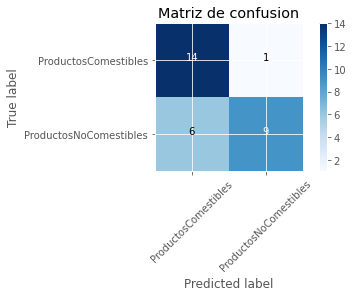

In [103]:
# Matriz de confusion
H=confusion_matrix(real_class_indices,predicted_class_indices)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
H_plot_labels=entrenamiento_generador.class_indices
plot_confusion_matrix(H,H_plot_labels, title='Matriz de confusion')


In [104]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(real_class_indices,predicted_class_indices)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(real_class_indices,predicted_class_indices)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(real_class_indices,predicted_class_indices)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(real_class_indices,predicted_class_indices)
print('F1 score: %f' % f1)

Accuracy: 0.766667
Precision: 0.900000
Recall: 0.600000
F1 score: 0.720000
